In [1]:
%matplotlib inline

import glob
import os
import re
import pandas
import numpy
import sklearn
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

/Users/rsharp/PROJECTS/rws_project_python/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
teams = pandas.read_csv('data/kaggle_2018_final/DataFiles/Teams.csv')
slots = pandas.read_csv('slots_2018.csv')
seeds = pandas.read_csv('seeds_2018.csv')

In [3]:
def predicted_round_results(r):
    season = 2018
    daynum = -1
    wloc = 'X'
    numot = -1

    results = {
        'Season': list(),
        'DayNum': list(),
        'WTeamID': list(),
        'WScore': list(),
        'LTeamID': list(),
        'LScore': list(),
        'WLoc': list(),
        'NumOT': list(),
        'minID': list(),
        'maxID': list()
    }
    
    for idx, row in r.iterrows():
        
        sid = row['StrongTeamID']
        wid = row['WeakTeamID']

        if all([~numpy.isnan(sid), ~numpy.isnan(wid)]):    
            minid = min(sid, wid)
            maxid = max(sid, wid)
            
            # Play-in results:
            if (minid, maxid) == (1382, 1417):
                # UCLA: 1417 (58), St Bonaventure: 1382 (65)
                win_id  = 1382
                loss_id = 1417
                win_sc  = 65
                loss_sc = 58
            elif (minid, maxid) == (1134, 1347):
                # Radford: 1347 (71), Brooklyn: 1134 (61)
                win_id  = 1347
                loss_id = 1134
                win_sc  = 71
                loss_sc = 61
            elif (minid, maxid) == (1300, 1411):
                # TX Southern: 1411 (64), NC Central: 1300 (46)
                win_id  = 1411
                loss_id = 1300
                win_sc  = 64
                loss_sc = 46
            elif (minid, maxid) == (1113, 1393):
                # Arizona St: 1113 (56), Syracuse: 1393 (60) 
                win_id  = 1393
                loss_id = 1113
                win_sc  = 60
                loss_sc = 56
            elif row['StrongTeamRank'] <= row['WeakTeamRank']:
                # Strong seed is higher ranked and wins
                win_id = sid
                loss_id = wid
                win_sc = 1
                loss_sc = 0
            else:
                # Week seed is higher ranked and wins
                win_id = wid
                loss_id = sid
                win_sc = 1
                loss_sc = 0

            results['Season'].append(season)
            results['DayNum'].append(daynum)
            results['WTeamID'].append(win_id)
            results['WScore'].append(win_sc)
            results['LTeamID'].append(loss_id)
            results['LScore'].append(loss_sc)
            results['WLoc'].append(wloc)
            results['NumOT'].append(numot)
            results['minID'].append(minid)
            results['maxID'].append(maxid)

    results = pandas.DataFrame(results)
    
    return results

In [128]:
def compute_rounds(bracket_file_name):
    season = 2018

    bracket_data = pandas.read_csv(bracket_file_name, sep='|')

    final_teams = list()

    winners = dict([rnd, list()] for rnd in [1, 2, 3, 4, 5, 6])

    # initialize
    df = slots.merge(seeds, left_on=['Season', 'StrongSeed'], right_on=['Season', 'Seed'], how='left')
    df = df.rename(index=str, columns={"TeamID": "StrongTeamID"}).drop('Seed', axis=1)
    df = df.merge(seeds, left_on=['Season', 'WeakSeed'], right_on=['Season', 'Seed'], how='left')
    df = df.rename(index=str, columns={"TeamID": "WeakTeamID"}).drop('Seed', axis=1)

    # reduce to the 68 teams in the tourney
    # teams_68 = map(int, list(df['StrongTeamID']) + list(df['WeakTeamID']))
    teams_68 = map(int, set([id for id in list(df['StrongTeamID']) + list(df['WeakTeamID']) if not numpy.isnan(id)]))
    bracket_68 = bracket_data[bracket_data['TeamID'].isin(teams_68)].copy()

    rnd = 0
    df = df.merge(bracket_68[['TeamID', 'Rank_{}'.format(rnd)]], left_on='StrongTeamID', right_on='TeamID', how='left')
    df = df.rename(index=str, columns={"Rank_{}".format(rnd): "StrongTeamRank"}).drop('TeamID', axis=1)
    df = df.merge(bracket_68[['TeamID', 'Rank_{}'.format(rnd)]], left_on='WeakTeamID', right_on='TeamID', how='left')
    df = df.rename(index=str, columns={"Rank_{}".format(rnd): "WeakTeamRank"}).drop('TeamID', axis=1)

    # play-in games
    pi_games = ~(df['Slot'].str.contains('R')) & (df['Season'] == season)
    pi = df[pi_games].copy()

    pi.loc[pi_games, 'minID'] = pi[['StrongTeamID', 'WeakTeamID']].min(axis=1)
    pi.loc[pi_games, 'maxID'] = pi[['StrongTeamID', 'WeakTeamID']].max(axis=1)

    results = predicted_round_results(pi)

    pi = pi.merge(results, on=['Season', 'minID', 'maxID'], how='left')

    pi = pi.merge(teams[['TeamID', 'TeamName']], left_on=['StrongTeamID'], right_on=['TeamID'], how='left')
    pi = pi.rename(index=str, columns={"TeamName": "StrongTeamName"}).drop('TeamID', axis=1)
    pi = pi.merge(teams[['TeamID', 'TeamName']], left_on=['WeakTeamID'], right_on=['TeamID'], how='left')
    pi = pi.rename(index=str, columns={"TeamName": "WeakTeamName"}).drop('TeamID', axis=1)
    pi = pi.merge(teams[['TeamID', 'TeamName']], left_on=['WTeamID'], right_on=['TeamID'], how='left')
    pi = pi.rename(index=str, columns={"TeamName": "WTeamName"}).drop('TeamID', axis=1)
    pi = pi.merge(teams[['TeamID', 'TeamName']], left_on=['LTeamID'], right_on=['TeamID'], how='left')
    pi = pi.rename(index=str, columns={"TeamName": "LTeamName"}).drop('TeamID', axis=1)

    pi.loc[pi['StrongTeamID'] == pi['WTeamID'], 'WTeamRank'] = pi['StrongTeamRank']
    pi.loc[pi['WeakTeamID']   == pi['WTeamID'], 'WTeamRank'] = pi['WeakTeamRank']
    pi.loc[pi['StrongTeamID'] == pi['LTeamID'], 'LTeamRank'] = pi['StrongTeamRank']
    pi.loc[pi['WeakTeamID']   == pi['LTeamID'], 'LTeamRank'] = pi['WeakTeamRank']

    # regular rounds
    rounds = [pi]

    for rnd in range(1, 6 + 1):
        last_rnd = rounds[-1]

        r_games = (df['Slot'].str.contains('R{}..'.format(rnd))) & (df['Season'] == season)
        r = df[r_games].copy()

        r = r.merge(last_rnd[['Slot', 'WTeamID']], left_on='StrongSeed', right_on='Slot', how='left', suffixes=['', '__'])
        r.loc[r['StrongTeamID'].isnull(), 'StrongTeamID'] = r['WTeamID']
        r = r.drop(['Slot__', 'WTeamID'], axis=1)

        r = r.merge(last_rnd[['Slot', 'WTeamID']], left_on='WeakSeed', right_on='Slot', how='left', suffixes=['', '__'])
        r.loc[r['WeakTeamID'].isnull(), 'WeakTeamID'] = r['WTeamID']
        r = r.drop(['Slot__', 'WTeamID'], axis=1)

        r['minID'] = r[['StrongTeamID', 'WeakTeamID']].min(axis=1)
        r['maxID'] = r[['StrongTeamID', 'WeakTeamID']].max(axis=1)

        # make sure to use the ranking for the correct round #
        r['StrongTeamRank'] = r.merge(bracket_68[['TeamID', 'Rank_{}'.format(rnd)]], left_on='StrongTeamID', right_on='TeamID', how='left')['Rank_{}'.format(rnd)]
        r['WeakTeamRank'] = r.merge(bracket_68[['TeamID', 'Rank_{}'.format(rnd)]], left_on='WeakTeamID', right_on='TeamID', how='left')['Rank_{}'.format(rnd)]

        results = predicted_round_results(r)

        r = r.merge(results, on=['Season', 'minID', 'maxID'], how='left')

        r = r.merge(teams[['TeamID', 'TeamName']], left_on=['StrongTeamID'], right_on=['TeamID'], how='left')
        r = r.rename(index=str, columns={"TeamName": "StrongTeamName"}).drop('TeamID', axis=1)
        r = r.merge(teams[['TeamID', 'TeamName']], left_on=['WeakTeamID'], right_on=['TeamID'], how='left')
        r = r.rename(index=str, columns={"TeamName": "WeakTeamName"}).drop('TeamID', axis=1)
        r = r.merge(teams[['TeamID', 'TeamName']], left_on=['WTeamID'], right_on=['TeamID'], how='left')
        r = r.rename(index=str, columns={"TeamName": "WTeamName"}).drop('TeamID', axis=1)
        r = r.merge(teams[['TeamID', 'TeamName']], left_on=['LTeamID'], right_on=['TeamID'], how='left')
        r = r.rename(index=str, columns={"TeamName": "LTeamName"}).drop('TeamID', axis=1)

        winners[rnd].append(list(r['WTeamName']))

        r.loc[r['StrongTeamID'] == r['WTeamID'], 'WTeamRank'] = r['StrongTeamRank']
        r.loc[r['WeakTeamID']   == r['WTeamID'], 'WTeamRank'] = r['WeakTeamRank']
        r.loc[r['StrongTeamID'] == r['LTeamID'], 'LTeamRank'] = r['StrongTeamRank']
        r.loc[r['WeakTeamID']   == r['LTeamID'], 'LTeamRank'] = r['WeakTeamRank']
        
        rounds.append(r.copy())
        
    return rounds

In [129]:
def compute_predicted_bracket(rounds):
    predicted_bracket = {'Round': list(), 
                         'Slot': list(), 
                         'StrongTeamID': list(),
                         'WeakTeamID': list(),
                         'WTeamRank': list(),
                         'LTeamRank': list(),
                         'WTeamID': list(),
                         'LTeamID': list()}
    for rnd in [0, 1, 2, 3, 4, 5, 6]:
        for idx, row in rounds[rnd][['Slot', 'StrongTeamID', 'WeakTeamID', 'WTeamRank', 'LTeamRank', 'WTeamID', 'LTeamID']].iterrows():
            predicted_bracket['Round'].append(rnd)
            predicted_bracket['Slot'].append(row['Slot'])
            predicted_bracket['WTeamID'].append(int(row['WTeamID']))
            predicted_bracket['LTeamID'].append(int(row['LTeamID']))
            predicted_bracket['StrongTeamID'].append(int(row['StrongTeamID']))
            predicted_bracket['WeakTeamID'].append(int(row['WeakTeamID']))
            predicted_bracket['WTeamRank'].append(float(row['WTeamRank']))
            predicted_bracket['LTeamRank'].append(float(row['LTeamRank']))

    predicted_bracket = pandas.DataFrame(predicted_bracket)
    predicted_bracket = predicted_bracket.merge(teams[['TeamID', 'TeamName']], left_on='WTeamID', right_on='TeamID')
    predicted_bracket = predicted_bracket.rename(index=str, columns={"TeamName": "WTeamName"}).drop('TeamID', axis=1)
    predicted_bracket = predicted_bracket.merge(teams[['TeamID', 'TeamName']], left_on='LTeamID', right_on='TeamID')
    predicted_bracket = predicted_bracket.rename(index=str, columns={"TeamName": "LTeamName"}).drop('TeamID', axis=1)
    predicted_bracket = predicted_bracket.merge(seeds[['TeamID', 'Seed']], left_on='WTeamID', right_on='TeamID')
    predicted_bracket = predicted_bracket.rename(index=str, columns={"Seed": "WSeed"}).drop('TeamID', axis=1)
    predicted_bracket = predicted_bracket.merge(seeds[['TeamID', 'Seed']], left_on='LTeamID', right_on='TeamID')
    predicted_bracket = predicted_bracket.rename(index=str, columns={"Seed": "LSeed"}).drop('TeamID', axis=1)

    # What about ties? There is no tie, only win or not win. If two teams with the same seed meet, you cannot 
    # have an upset, even though, technically, the tourney committee has ranked one higher than the other.
    upsets = (predicted_bracket['WSeed'] > predicted_bracket['LSeed'])
    predicted_bracket['PredictedUpset'] = False
    predicted_bracket.loc[upsets, 'PredictedUpset'] = True

    # Note: Here's the old code for upsets. It used WeakTeamID to identify the underdog. This works in Round 1,
    # but fails in later rounds after an actual upset because the WeakTeam refferes to the slot, not the actual
    # seed of the team occupying the slot.
    #upsets = (predicted_bracket['WTeamID'] == predicted_bracket['WeakTeamID'])

    
    return predicted_bracket

In [130]:
ncaa_2018 = pandas.read_excel('results_2018.xlsx', sheet_name='slots_2018')

ncaa_2018['Round'] = 0
for i in range(1, 6+1):
    games = ncaa_2018['Slot'].str.contains('R{}'.format(i))
    ncaa_2018.loc[games, 'Round'] = i
    
ncaa_2018 = ncaa_2018.merge(teams[['TeamID', 'TeamName']], left_on='WTeamID', right_on='TeamID')
ncaa_2018 = ncaa_2018.rename(index=str, columns={"TeamName": "WTeamName"}).drop('TeamID', axis=1)
ncaa_2018 = ncaa_2018.merge(teams[['TeamID', 'TeamName']], left_on='LTeamID', right_on='TeamID')
ncaa_2018 = ncaa_2018.rename(index=str, columns={"TeamName": "LTeamName"}).drop('TeamID', axis=1)
ncaa_2018 = ncaa_2018.merge(seeds[['TeamID', 'Seed']], left_on='WTeamID', right_on='TeamID')
ncaa_2018 = ncaa_2018.rename(index=str, columns={"Seed": "WSeed"}).drop('TeamID', axis=1)
ncaa_2018 = ncaa_2018.merge(seeds[['TeamID', 'Seed']], left_on='LTeamID', right_on='TeamID')
ncaa_2018 = ncaa_2018.rename(index=str, columns={"Seed": "LSeed"}).drop('TeamID', axis=1)

ncaa_2018['WSeed'] = ncaa_2018['WSeed'].apply(lambda s: int(re.search('.*(\d\d).*', str(s)).groups()[0]))
ncaa_2018['LSeed'] = ncaa_2018['LSeed'].apply(lambda s: int(re.search('.*(\d\d).*', str(s)).groups()[0]))

ncaa_2018.loc[ncaa_2018['WTeamID'] == ncaa_2018['StrongTeamID'], 'WTeamScore'] = ncaa_2018['StrongTeamScore']
ncaa_2018.loc[ncaa_2018['WTeamID'] == ncaa_2018['StrongTeamID'], 'LTeamScore'] = ncaa_2018['WeakTeamScore']
ncaa_2018.loc[ncaa_2018['WTeamID'] == ncaa_2018['WeakTeamID'], 'WTeamScore'] = ncaa_2018['WeakTeamScore']
ncaa_2018.loc[ncaa_2018['WTeamID'] == ncaa_2018['WeakTeamID'], 'LTeamScore'] = ncaa_2018['StrongTeamScore']

# What about ties? There is no tie, only win or not win. If two teams with the same seed meet, you cannot 
# have an upset, even though, technically, the tourney committee has ranked one higher than the other.
upsets = (ncaa_2018['WSeed'] > ncaa_2018['LSeed'])
ncaa_2018['Upset'] = False
ncaa_2018.loc[upsets, 'Upset'] = True

acols = ['Round', 'Slot', 'WSeed', 'WTeamID', 'WTeamName', 'LSeed', 'LTeamID', 'LTeamName', 'Upset']
ncaa_2018[ncaa_2018['Round'] == 5][acols + ['Projected']].sort_values(['Round', 'Slot'])

,Round,Slot,WSeed,WTeamID,WTeamName,LSeed,LTeamID,LTeamName,Upset,Projected
9,5,R5WX,1,1462,Xavier,16,1420,UMBC,False,True
41,5,R5YZ,1,1437,Villanova,1,1242,Kansas,False,True


In [136]:
def compute_stats(predicted_bracket, weights):
    in_progress_results = predicted_bracket.merge(ncaa_2018[ncaa_2018['Projected'] == False], on='Slot', suffixes=('', '_actual'), how='left')

    played = ~in_progress_results['StrongTeamScore'].isnull()
    games = (in_progress_results['WTeamID'] == in_progress_results['WTeamID_actual']) & played
    in_progress_results.loc[games, 'Correct'] = True
    games = (in_progress_results['WTeamID'] != in_progress_results['WTeamID_actual']) & played
    in_progress_results.loc[games, 'Correct'] = False

    in_progress_results['PointsEarned'] = (in_progress_results['Round'].apply(lambda x: weights[x]))
    in_progress_results.loc[in_progress_results['Correct'] != True, 'PointsEarned'] = 0

    in_progress_results.loc[in_progress_results['Round'].isin([0, 1]), 'WTeamPossible'] = True
    teams_remaining = in_progress_results.loc[(in_progress_results['Correct'] != False) & \
                                              (in_progress_results['Round'] == 1), 'WTeamID']
    for rnd in range(2, 6+1):
        in_progress_results.loc[in_progress_results['Round'] == rnd, 'WTeamPossible'] = \
            in_progress_results['WTeamID'].isin(teams_remaining)

        teams_remaining = in_progress_results.loc[(in_progress_results['Correct'] != False) & \
                                                  (in_progress_results['Round'] == rnd) & \
                                                  (in_progress_results['WTeamPossible'] == True), 'WTeamID']

    in_progress_results['PointsPossible'] = (in_progress_results['Round'].apply(lambda x: weights[x]))
    in_progress_results.loc[in_progress_results['WTeamPossible'] != True, 'PointsPossible'] = 0

    in_progress_results['PointsPerfect'] = (in_progress_results['Round'].apply(lambda x: weights[x]))


    # total points possible = total earned in games played + total still possible in games not played
    stats = dict()
    
    total_earned = 0
    total_points_possible = 0
    header = [
        'Round', 'Pts_Earned', 'Pts_Possible', 'Tot_Earned', 'Tot_Possible',
        'Pred_Upsets', 'Act_Upsets', 'Corr_Pred_Upsets']
    #print '\t'.join(header)
    for rnd in range(1, 6+1):
        earned   = in_progress_results.loc[played  & (in_progress_results['Round'] == rnd), 'PointsEarned'].sum()
        possible = in_progress_results.loc[~played & (in_progress_results['Round'] == rnd), 'PointsPossible'].sum()

        total_earned += earned
        total_points_possible += earned + possible

        in_round = (in_progress_results['Round'] == rnd)
        is_upset = (in_progress_results['Upset'] == True)
        is_predicted_upset = (in_progress_results['PredictedUpset'] == True)
        predicted_eq_actual = (in_progress_results['PredictedUpset'] == in_progress_results['Upset']) 

        predicted_upsets           = (in_round & is_predicted_upset).sum()
        #actual_upsets              = (in_round & is_upset).sum()
        actual_upsets              = in_progress_results[in_round & is_upset][['WTeamID_actual', 'LTeamID_actual', 'WTeamRank', 'LTeamRank']]
        correctly_predicted_upsets = (in_round & is_upset & predicted_eq_actual).sum()

        stats_data = [
            rnd, earned, possible, total_earned, total_points_possible,
            predicted_upsets, actual_upsets, correctly_predicted_upsets  
        ]

        # print ('{}\t'*8).format(*stats_data)
        stats[rnd] = dict([(field, value) for field, value in zip(header, stats_data)])

    return stats
    

In [137]:
weights = {
    0: 0,
    1: 1,
    2: 2,
    3: 4,
    4: 8,
    5: 16,
    6: 32
}

earned = list()
possible = list()

for i in range(4):
    bracket_name = 'bracket_a01_b15_s10_pen_{:04d}.csv'.format(i)
    print bracket_name
    rounds = compute_rounds(os.path.join('data/brackets/', bracket_name))
    predicted_bracket = compute_predicted_bracket(rounds)

    pcols = ['Round', 'Slot', 'WSeed', 'WTeamID', 'WTeamName', 'LSeed', 'LTeamID', 'LTeamName', 'PredictedUpset']
    predicted_bracket[predicted_bracket['Round'] == 5][pcols].sort_values(['Round', 'Slot'])

    stats = compute_stats(predicted_bracket, weights)
    earned.append(stats[6]['Tot_Earned'])
    possible.append(stats[6]['Tot_Possible'])

bracket_a01_b15_s10_pen_0000.csv
bracket_a01_b15_s10_pen_0001.csv
bracket_a01_b15_s10_pen_0002.csv
bracket_a01_b15_s10_pen_0003.csv


In [138]:
stats[1]['Act_Upsets']

,WTeamID_actual,LTeamID_actual,WTeamRank,LTeamRank
18,1199.0,1281.0,0.574237,0.672795
19,1420.0,1438.0,0.151346,2.986806
30,1138.0,1112.0,0.077606,1.214192
33,1260.0,1274.0,0.146385,0.734746
35,1243.0,1166.0,0.351778,0.784644
46,1267.0,1455.0,0.141080,1.858345
50,1139.0,1116.0,0.232816,0.557831
51,1104.0,1439.0,0.525621,0.729378
64,1393.0,1395.0,0.557579,1.000914


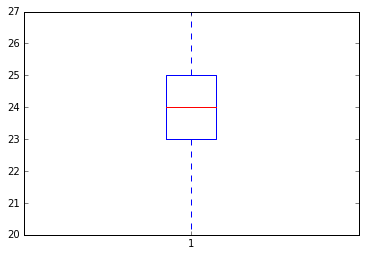

In [66]:
plt.boxplot(earned);

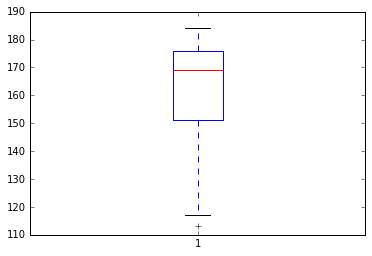

In [67]:
plt.boxplot(possible);

In [68]:
stats = dict()

for bracket_name in glob.glob('data/brackets/*'):
    bracket_name = os.path.split(bracket_name)[1]
    match = re.search('(.*)_(\d{4}).csv', bracket_name)
    bracket_family, bracket_id = match.groups()

    if bracket_id >= '005':
        continue
    
    if bracket_family not in stats:
        print bracket_family

    stats.setdefault(bracket_family, dict())

    rounds = compute_rounds(os.path.join('data/brackets/', bracket_name))
    predicted_bracket = compute_predicted_bracket(rounds)        
    stats[bracket_family][bracket_id] = compute_stats(predicted_bracket, weights)
        

bracket_a00_b05_sNA
bracket_a00_b15_sNA
bracket_a01_b00_s06
bracket_a01_b00_s10_pen
bracket_a01_b05_s06_pen
bracket_a01_b05_s10_pen
bracket_a01_b15_s06_pen
bracket_a01_b15_s10_pen
bracket_a02_b00_s06
bracket_a02_b00_s10_pen
bracket_pp


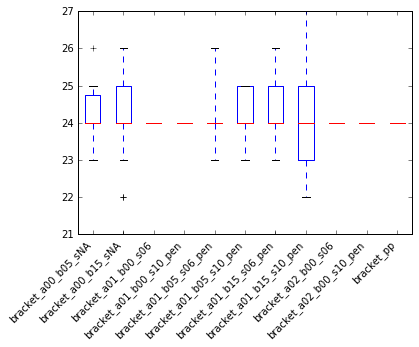

In [69]:
families = sorted(stats.keys())
tot_earned_by_family = list()
for bracket_family in families:
    tot_earned = list()
    for id, br_stats in stats[bracket_family].iteritems():
        tot_earned.append(br_stats[6]['Tot_Earned'])
    tot_earned_by_family.append(tot_earned)
    
plt.boxplot(tot_earned_by_family);
plt.xticks(range(1,len(families)+1), families, rotation=45, ha='right');

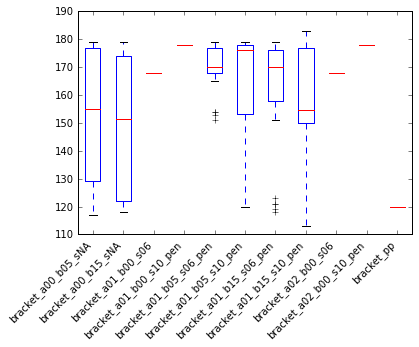

In [70]:
families = sorted(stats.keys())
tot_earned_by_family = list()
for bracket_family in families:
    tot_earned = list()
    for id, br_stats in stats[bracket_family].iteritems():
        tot_earned.append(br_stats[6]['Tot_Possible'])
    tot_earned_by_family.append(tot_earned)
    
plt.boxplot(tot_earned_by_family);
plt.xticks(range(1,len(families)+1), families, rotation=45, ha='right');

In [71]:
families = sorted(stats.keys())
tot_earned_by_family = list()
for bracket_family in families:
    tot_earned = list()
    for id, br_stats in stats[bracket_family].iteritems():
        print br_stats[1]
        break
    break

{'Tot_Possible': 24, 'Tot_Earned': 24, 'Corr_Pred_Upsets': 1, 'Pred_Upsets': 1, 'Act_Upsets':     WTeamID_actual  LTeamID_actual
18          1199.0          1281.0
19          1420.0          1438.0
29          1138.0          1112.0
32          1260.0          1274.0
34          1243.0          1166.0
46          1267.0          1455.0
50          1139.0          1116.0
51          1104.0          1439.0
64          1393.0          1395.0, 'Pts_Earned': 24, 'Pts_Possible': 0, 'Round': 1}


In [94]:
temp = br_stats[1]['Act_Upsets'].rename(index=str, columns={"WTeamID_actual": "WTeamID", "LTeamID_actual": "LTeamID"})
temp = temp.merge(seeds[['TeamID', 'Seed']], left_on='WTeamID', right_on='TeamID', how='left')
temp = temp.rename(index=str, columns={"Seed": "WSeed"}).drop('TeamID', axis=1)
temp = temp.merge(seeds[['TeamID', 'Seed']], left_on='LTeamID', right_on='TeamID', how='left')
temp = temp.rename(index=str, columns={"Seed": "LSeed"}).drop('TeamID', axis=1)
temp = temp.merge(teams[['TeamID', 'TeamName']], left_on='WTeamID', right_on='TeamID', how='left')
temp = temp.rename(index=str, columns={"TeamName": "WTeamName"}).drop('TeamID', axis=1)
temp = temp.merge(teams[['TeamID', 'TeamName']], left_on='LTeamID', right_on='TeamID', how='left')
temp = temp.rename(index=str, columns={"TeamName": "LTeamName"}).drop('TeamID', axis=1)

temp = temp.merge(ncaa_2018[['WTeamID', 'LTeamID', 'Round', 'WTeamScore', 'LTeamScore']], on=['WTeamID', 'LTeamID'], how='left')

wseed_int = temp['WSeed'].apply(lambda s: int(re.search('.*(\d\d).*', str(s)).groups()[0]))
lseed_int = temp['LSeed'].apply(lambda s: int(re.search('.*(\d\d).*', str(s)).groups()[0]))
temp['DeltaSeed'] = (wseed_int - lseed_int)

temp['DeltaScore'] = temp['WTeamScore'] - temp['LTeamScore']

temp[['Round', 
      'WSeed', 'WTeamID', 'WTeamName', 'WTeamScore', 
      'LSeed', 'LTeamID', 'LTeamName', 'LTeamScore',
      'DeltaSeed', 'DeltaScore']]

,Round,WSeed,WTeamID,WTeamName,WTeamScore,LSeed,LTeamID,LTeamName,LTeamScore,DeltaSeed,DeltaScore
0,1,W09,1199.0,Florida St,67.0,W08,1281.0,Missouri,54.0,1,13.0
1,1,X16,1420.0,UMBC,74.0,X01,1438.0,Virginia,54.0,15,20.0
2,1,X13,1138.0,Buffalo,89.0,X04,1112.0,Arizona,68.0,9,21.0
3,1,X11,1260.0,Loyola-Chicago,64.0,X06,1274.0,Miami FL,62.0,5,2.0
4,1,X09,1243.0,Kansas St,69.0,X08,1166.0,Creighton,59.0,1,10.0
5,1,Y13,1267.0,Marshall,81.0,Y04,1455.0,Wichita St,75.0,9,6.0
6,1,Y10,1139.0,Butler,79.0,Y07,1116.0,Arkansas,62.0,3,17.0
7,1,Y09,1104.0,Alabama,86.0,Y08,1439.0,Virginia Tech,83.0,1,3.0
8,1,Z11b,1393.0,Syracuse,57.0,Z06,1395.0,TCU,52.0,5,5.0
